In [55]:

import random
import warnings
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import itertools
from itertools import combinations, permutations, chain


warnings.filterwarnings("ignore")
import networkx as nx
import matplotlib.pyplot as plt
import json

from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete.CPD import TabularCPD

# Asia Network

In [76]:
def is_valid_subset(G, subset):
    """
    Checks if a subset of nodes is valid under do-intervention rules.
    Each node in the subset must include all its predecessors from the graph.
    """
    # check whether the input subset is valid (must have a route to y)
    subG = G.subgraph(subset).copy()
    
    if not nx.is_connected(subG.to_undirected()):
        return False

    for node in subset:
        parents = set(G.predecessors(node))
        parents_included = parents.intersection(subset)
        if len(parents_included) != 0:
            if len(parents_included) < len(parents):
                return False
    return True

In [77]:
G = nx.DiGraph()

G.add_nodes_from(["asia", "smoke", "tub", "lung", "bronc", "either", "xray", "dysp"])
edges = [
    # tuple of direction (from, to)
    ("asia", "tub"),
    ("smoke", "lung"),
    ("smoke", "bronc"),
    ("tub", "either"),
    ("lung", "either"),
    ("either", "xray"),
    ("either", "dysp"),
    ("bronc", "dysp"),
]
G.add_edges_from(edges)

# initiate BN
dataset = pd.read_csv('../data/asia10K.csv')
asia_bn = BayesianNetwork(edges)
asia_bn.fit(dataset)
asia_bn.get_cpds()

[<TabularCPD representing P(asia:2) at 0x21f8a199610>,
 <TabularCPD representing P(tub:2 | asia:2) at 0x21f8a1995b0>,
 <TabularCPD representing P(smoke:2) at 0x21f8a1995e0>,
 <TabularCPD representing P(lung:2 | smoke:2) at 0x21f8a199460>,
 <TabularCPD representing P(bronc:2 | smoke:2) at 0x21f8a199400>,
 <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x21f8a199430>,
 <TabularCPD representing P(xray:2 | either:2) at 0x21f8a199580>,
 <TabularCPD representing P(dysp:2 | bronc:2, either:2) at 0x21f8a199520>]

In [78]:
valid_combination = []
for r in range(1, len(G.nodes)):
    for comb in combinations(set(G.nodes) - {'lung'}, r):
        if is_valid_subset(G, set(comb) | {'lung'}):
            valid_combination.append(set(comb) | {'lung'})
valid_combination

[{'lung', 'smoke'},
 {'bronc', 'lung', 'smoke'},
 {'either', 'lung', 'tub'},
 {'either', 'lung', 'smoke', 'tub'},
 {'either', 'lung', 'tub', 'xray'},
 {'asia', 'either', 'lung', 'tub'},
 {'bronc', 'either', 'lung', 'smoke', 'tub'},
 {'either', 'lung', 'smoke', 'tub', 'xray'},
 {'asia', 'either', 'lung', 'smoke', 'tub'},
 {'bronc', 'dysp', 'either', 'lung', 'tub'},
 {'asia', 'either', 'lung', 'tub', 'xray'},
 {'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub'},
 {'bronc', 'either', 'lung', 'smoke', 'tub', 'xray'},
 {'asia', 'bronc', 'either', 'lung', 'smoke', 'tub'},
 {'asia', 'either', 'lung', 'smoke', 'tub', 'xray'},
 {'bronc', 'dysp', 'either', 'lung', 'tub', 'xray'},
 {'asia', 'bronc', 'dysp', 'either', 'lung', 'tub'},
 {'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub', 'xray'},
 {'asia', 'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub'},
 {'asia', 'bronc', 'either', 'lung', 'smoke', 'tub', 'xray'},
 {'asia', 'bronc', 'dysp', 'either', 'lung', 'tub', 'xray'},
 {'asia', 'bronc', 'd

In [79]:
def intervention(bn, G, subset):
    other = set(G.nodes) - subset
    
    for node in other:
        parents = set(G.predecessors(node))
        parent_included = parents.intersection(subset)
        if len(parent_included) > 0:
            bn = bn.do(node)

        childs = set(G.successors(node))
        child_included = childs.intersection(subset)
        if len(child_included) > 0:
            bn = bn.do(child_included)
            
    return bn
    
bn = intervention(asia_bn, G, valid_combination[4])
bn.get_cpds()

[<TabularCPD representing P(asia:2) at 0x21f8864ecd0>,
 <TabularCPD representing P(tub:2) at 0x21f886416d0>,
 <TabularCPD representing P(smoke:2) at 0x21f88641f40>,
 <TabularCPD representing P(lung:2) at 0x21f88641ca0>,
 <TabularCPD representing P(bronc:2 | smoke:2) at 0x21f88622490>,
 <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x21f886c32b0>,
 <TabularCPD representing P(xray:2 | either:2) at 0x21f886c3220>,
 <TabularCPD representing P(dysp:2) at 0x21f886c3040>]

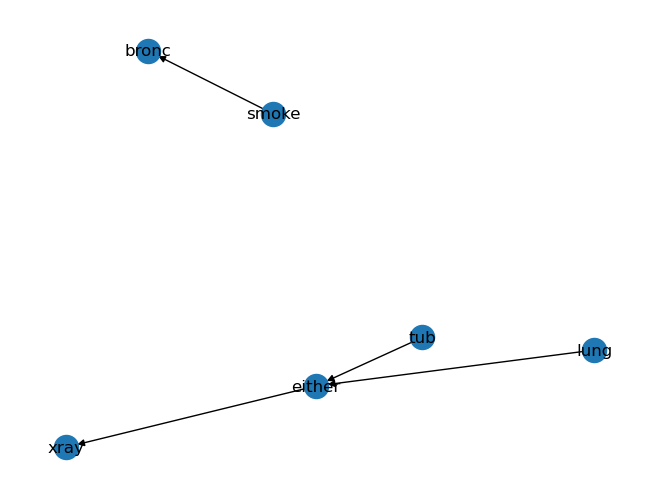

In [80]:
import matplotlib.pyplot as plt
nx.draw(nx.DiGraph(list(bn.edges)), with_labels=True)
plt.show()

# Shapley value

In [81]:
dataset.columns

Index(['smoke', 'lung', 'asia', 'tub', 'either', 'xray', 'bronc', 'dysp'], dtype='object')

In [ ]:
import itertools
import numpy as np

def shapley_values(model, input_data):
    # Number of features
    num_features = len(input_data)
    
    # Store the Shapley values
    shapley_vals = np.zeros(num_features)
    
    # The model's prediction for the full feature set
    full_pred = model_prediction(input_data)
    
    # Iterate over all feature permutations
    for perm in itertools.permutations(range(num_features)):
        prev_pred = 0  # Model prediction with no features
        prev_subset = []
        
        # Iterate over each feature in the permutation
        for i, feature_idx in enumerate(perm):
            # Create a new subset by including the current feature
            new_subset = prev_subset + [input_data[feature_idx]]
            
            # Make the model prediction with this new subset
            new_subset_full = input_data.copy()
            for j in range(num_features):
                if j not in prev_subset and j != feature_idx:
                    # Assign a baseline value for features not in the new subset
                    # This could be zero, the feature mean, or another appropriate value
                    new_subset_full[j] = 0  # or baseline_value
                
            new_pred = model_prediction(new_subset_full)
            
            # The marginal contribution of the current feature is the difference
            # in predictions with and without this feature
            marginal_contribution = new_pred - prev_pred
            
            # Update the Shapley value for the current feature
            shapley_vals[feature_idx] += marginal_contribution / num_features
            
            # Update the previous prediction and subset
            prev_pred = new_pred
            prev_subset.append(feature_idx)
    
    # Normalize the Shapley values
    shapley_vals /= np.math.factorial(num_features)
    
    return shapley_vals

# An example input instance (must be a list or array)
input_data = [1, 2, 3, 4]  # Example feature values

# Calculate Shapley values
shap_vals = shapley_values(model, input_data)
print(shap_vals)


In [84]:
# calculate the shaply value for feature j
j = 15
M = 1000
x = dataset.sample(1, random_state=10).values[0]
n_features = len(x)
marginal_contributions = []
feature_idxs = list(range(n_features))

In [143]:
def intervention(bn, G, subset):
    other = set(G.nodes) - subset
    
    for node in other:
        parents = set(G.predecessors(node))
        parent_included = parents.intersection(subset)
        if len(parent_included) > 0:
            bn = bn.do(node)

        childs = set(G.successors(node))
        child_included = childs.intersection(subset)
        if len(child_included) > 0:
            bn = bn.do(child_included)
            
    return bn
    
# bn = intervention(asia_bn, G, valid_combination[4])

In [189]:
# Model prediction handler for certain feature

# create valid subset

# run prediction on the valid subset

model = asia_bn
target = 'lung'
features = set(model.nodes) - {target}
print(features)
def prepare_model_prediction(bn, y, features):
    
    # print(f'target {y, features}')
    # if features is none
    if len(features) == 0:
        # null object, handle later
        return None
    
    # if feature not none, do intervention
    subset = set(features) | set([y])
    print('.........do intervention to save', subset)
    bn = intervention(bn, G, subset=subset)
    print(bn.get_cpds())
    return bn

feature_of_interest = 'smoke'
valid = []
for S in itertools.chain.from_iterable(itertools.combinations(set(features), r) for r in range(len(set(features)))):
    S_without_j = [feature for feature in S if feature != feature_of_interest]
    S_with_j = set(S_without_j) | {feature_of_interest}
    
    # check whether S_without_j + target are valid or not
    print('input features', S)
    print(f'feature without j = {S_without_j}')
    print(f'feature with j = {S_with_j}')
    
    if is_valid_subset(G, set(S_without_j) | {target}):
        # print(f'without i ({feature_of_interest}):',set(S_without_j) | {target})
        print('w/o valid')
        
        # prepare model with available feature (without and with j)
        model_without_j = prepare_model_prediction(asia_bn, target, S_without_j)
    else:
        model_without_j = None # cant construct model
        
    if is_valid_subset(G, set(S_with_j) | {target}):
        # print(f'with i ({feature_of_interest}):', set(S_with_j) | {target})
        model_with_j = prepare_model_prediction(asia_bn, target, S_with_j)
        print('w/ valid')
    else:
        model_with_j = None # cant construc model
    
    
    print()
    
        

{'smoke', 'tub', 'dysp', 'bronc', 'xray', 'asia', 'either'}
input features ()
feature without j = []
feature with j = {'smoke'}
w/o valid
.........do intervention to save {'lung', 'smoke'}
[<TabularCPD representing P(asia:2) at 0x21f8a057f70>, <TabularCPD representing P(tub:2 | asia:2) at 0x21f8a0575e0>, <TabularCPD representing P(smoke:2) at 0x21f8a0577f0>, <TabularCPD representing P(lung:2 | smoke:2) at 0x21f8a0570d0>, <TabularCPD representing P(bronc:2) at 0x21f8a057e20>, <TabularCPD representing P(either:2) at 0x21f8a057df0>, <TabularCPD representing P(xray:2 | either:2) at 0x21f8a0578b0>, <TabularCPD representing P(dysp:2 | bronc:2, either:2) at 0x21f8a057430>]
w/ valid

input features ('dysp',)
feature without j = ['dysp']
feature with j = {'dysp', 'smoke'}

input features ('smoke',)
feature without j = []
feature with j = {'smoke'}
w/o valid
.........do intervention to save {'lung', 'smoke'}
[<TabularCPD representing P(asia:2) at 0x21f8a0ecc40>, <TabularCPD representing P(tub:2 

In [193]:
model = asia_bn
target = 'lung'
features = set(model.nodes) - {target}
print(features)
def prepare_model_prediction(bn, y, features):
    # if features is none
    if len(features) == 0:
        return None
    
    # if feature not none, do intervention
    subset = set(features) | set([y])
    bn = intervention(bn, G, subset=subset)
    return bn

feature_of_interest = 'smoke'
valid = []
for S in itertools.chain.from_iterable(itertools.combinations(set(features), r) for r in range(len(set(features)))):
    S_without_j = [feature for feature in S if feature != feature_of_interest]
    S_with_j = set(S_without_j) | {feature_of_interest}
    
    # Model prediction handler for certain feature
    # check whether S_without_j + target are valid or not
    print('input features', S)
    print(f'feature without j = {S_without_j}')
    print(f'feature with j = {S_with_j}')
    
    # check valid subset
    if is_valid_subset(G, set(S_without_j) | {target}):
        # prepare model with available feature (without and with j)
        model_without_j = prepare_model_prediction(asia_bn, target, S_without_j)
    else:
        model_without_j = None # cant construct model
        
    if is_valid_subset(G, set(S_with_j) | {target}):
        model_with_j = prepare_model_prediction(asia_bn, target, S_with_j)
    else:
        model_with_j = None # cant construc model
    
    # run prediction on the valid subset using the prepared model
    if model_without_j:
        print('model without j valid')
    if model_with_j:
        print('model without j valid')
    print()
    
        

{'smoke', 'tub', 'dysp', 'bronc', 'xray', 'asia', 'either'}
input features ()
feature without j = []
feature with j = {'smoke'}
model without j valid

input features ('dysp',)
feature without j = ['dysp']
feature with j = {'dysp', 'smoke'}

input features ('smoke',)
feature without j = []
feature with j = {'smoke'}
model without j valid

input features ('bronc',)
feature without j = ['bronc']
feature with j = {'bronc', 'smoke'}
model without j valid

input features ('xray',)
feature without j = ['xray']
feature with j = {'xray', 'smoke'}

input features ('tub',)
feature without j = ['tub']
feature with j = {'tub', 'smoke'}

input features ('asia',)
feature without j = ['asia']
feature with j = {'asia', 'smoke'}

input features ('either',)
feature without j = ['either']
feature with j = {'smoke', 'either'}

input features ('dysp', 'smoke')
feature without j = ['dysp']
feature with j = {'dysp', 'smoke'}

input features ('dysp', 'bronc')
feature without j = ['dysp', 'bronc']
feature with 

In [120]:
data = {
    'X1': [1, 2, 3, 4],
    'X2': [10, 20, 30, 40],
    'X3': [100, 200, 300, 400],
    'Y': [0, 1, 0, 1]  # Binary target variable
}
df = pd.DataFrame(data)

def model_val(subset_features):
    # Create a dataframe with zeros for features not in the subset
    data_subset = pd.DataFrame(np.zeros((1, 3)), columns=['X1', 'X2', 'X3'])
    data_subset[subset_features] = df[subset_features].iloc[0]
    
    print(data_subset)
    # Return the model's prediction for this subset of features
    # return model.predict_proba(data_subset)[0][1]  # Probability of class 1

model_val(['X2', 'X3'])

    X1  X2   X3
0  0.0  10  100
